In [1]:
from my_packages import *

In [44]:
def categorize_nodes(mask, nx, ny):
    """
    Categorizes nodes into no-flow (0), constant head (negative), and active cells (positive).

    Parameters:
    - mask: 2D numpy array of shape (nx, ny) containing boundary values (0, negative, positive).
    - nx, ny: Grid dimensions.

    Returns:
    - nodes_by_type: A dictionary with keys "0", "negative", and "positive",
      each containing a list of nodes (i, j).
    """
    nodes_by_type = {"0": [], "negative": [], "positive": []}

    # Categorize nodes based on boundary values
    for i in range(nx):
        for j in range(ny):
            boundary_value = mask[i, j]
            if boundary_value == 0:
                nodes_by_type["0"].append((i, j))
            elif boundary_value < 0:
                nodes_by_type["negative"].append((i, j))
            elif boundary_value > 0:
                nodes_by_type["positive"].append((i, j))

    return nodes_by_type


# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
def identify_node_type(i, j, nx, ny):
    if j == 0:
        return "left"
    elif j == ny - 1:
        return "right"
    elif i == 0:
        return "top"
    elif i == nx - 1:
        return "bottom"
    else:
        return "inner"


# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
def reverse_node(node, nx):
    i = node % nx
    j = node // nx
    return i, j


# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
def map_result_to_grid(CC, nx, ny):
    grid = np.zeros((nx, ny))
    for node in range(len(CC)):
        i, j = reverse_no(node, nx)
        grid[i, j] = CC[node]
    return grid

In [56]:
# 	Matrix size
nx, ny = [10, 10]

# Boundary values
Tleft = 0.0
Tright = 0.0
Ttop = 20
Tbot = 0

# How big is your domain?
x0 = 0.0
xL = 1.0
y0 = 0.0
yL = 1.0

# Given parameter
# Q = (720/6.87)


# ------------------------------------------------------
# 			PROGRAM - PLEASE DO NOT MODIFY
# ------------------------------------------------------
# 	Matrix dimensions
AA = np.zeros((nx * ny, nx * ny))
BB = np.zeros(nx * ny)

# 	node function
no = lambda i, j: j * nx + i

# 	delta X, delta Y
dx = (xL - x0) / (nx - 1)
dy = (yL - x0) / (ny - 1)

# Given parameters
DX1, DY1 = [1.0, 1.0]


A1 = DX1 / pow(dx, 2)
A2 = DY1 / pow(dy, 2)
A3 = -2.0 * DX1 / pow(dx, 2) - 2.0 * DY1 / pow(dy, 2)
A4 = DY1 / pow(dy, 2)
A5 = DX1 / pow(dx, 2)
F = 0

ibound_array = np.zeros((nx, ny))
ibound_array[0, 1:-1] = -1  # top
ibound_array[-1, 1:-1] = -2  # bottom
ibound_array[1:-1, 1:-1] = 1

constant_head = {-1: Ttop, -2: Tbot}

nodes_by_type = categorize_nodes(ibound_array, nx, ny)

for i, j in nodes_by_type["0"]:
    node_loc = identify_node_type(i, j, nx, ny)
    nn = no(i, j)
    if node_loc == "left":
        mm = no(i, j + 1)
    elif node_loc == "right":
        mm = no(i, j - 1)
    elif node_loc == "top":
        mm = no(i + 1, j)
    elif node_loc == "bottom":
        mm = no(i - 1, j)
    else:
        continue
    AA[nn][nn] = 1.0 / dx
    AA[nn][mm] = -1.0 / dx
    BB[nn] = 0

for i, j in nodes_by_type["negative"]:
    nn = no(i, j)
    boundary_value = ibound_array[i, j]
    AA[nn][nn] = 1
    BB[nn] = constant_head[boundary_value]

for i, j in nodes_by_type["positive"]:
    nn = no(i, j)
    nl = no(i, j - 1)
    nr = no(i, j + 1)
    nu = no(i - 1, j)
    nd = no(i + 1, j)
    AA[nn][nl] = A1
    AA[nn][nd] = A2
    AA[nn][nn] = A3
    AA[nn][nu] = A4
    AA[nn][nr] = A5
    BB[nn] = 0

In [57]:
from numpy.linalg import solve

CC = solve(np.array(AA, dtype=np.float32), np.array(BB, dtype=np.float32))

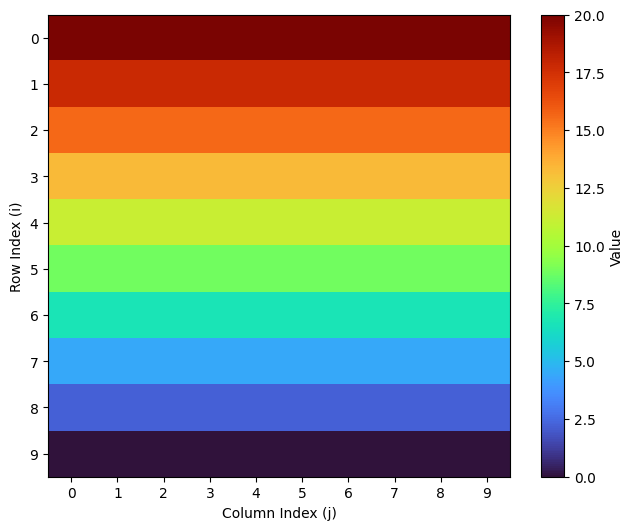

In [58]:
grid = reshape_to_grid(CC, nx, ny)

plt.figure(figsize=(8, 6))
plt.imshow(grid, cmap='turbo', origin='upper', interpolation='none')
plt.colorbar(label='Value')
plt.xlabel('Column Index (j)')
plt.ylabel('Row Index (i)')
plt.xticks(ticks=np.arange(grid.shape[1]), labels=np.arange(grid.shape[1]))
plt.yticks(ticks=np.arange(grid.shape[0]), labels=np.arange(grid.shape[0]))
plt.show()